In [26]:
import scipy.misc
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from collections import namedtuple


model_dir='./runs/model/'
segmentation_model  = os.path.join(model_dir, 'frozen_graph.pb')
print(segmentation_model)


Label = namedtuple('Label', ['name', 'color'])

label_defs = [
    Label('unlabeled',     (0,     0,   0)),
    Label('dynamic',       (111,  74,   0)),
    Label('ground',        ( 81,   0,  81)),
    Label('road',          (128,  64, 128)),
    Label('sidewalk',      (244,  35, 232)),
    Label('parking',       (250, 170, 160)),
    Label('rail track',    (230, 150, 140)),
    Label('building',      ( 70,  70,  70)),
    Label('wall',          (102, 102, 156)),
    Label('fence',         (190, 153, 153)),
    Label('guard rail',    (180, 165, 180)),
    Label('bridge',        (150, 100, 100)),
    Label('tunnel',        (150, 120,  90)),
    Label('pole',          (153, 153, 153)),
    Label('traffic light', (250, 170,  30)),
    Label('traffic sign',  (220, 220,   0)),
    Label('vegetation',    (107, 142,  35)),
    Label('terrain',       (152, 251, 152)),
    Label('sky',           ( 70, 130, 180)),
    Label('person',        (220,  20,  60)),
    Label('rider',         (255,   0,   0)),
    Label('car',           (  0,   0, 142)),
    Label('truck',         (  0,   0,  70)),
    Label('bus',           (  0,  60, 100)),
    Label('caravan',       (  0,   0,  90)),
    Label('trailer',       (  0,   0, 110)),
    Label('train',         (  0,  80, 100)),
    Label('motorcycle',    (  0,   0, 230)),
    Label('bicycle',       (119, 11, 32))]


class SSeg(object):
    def __init__(self):
        #TODO load classifier

        self.graph=tf.Graph()

        with self.graph.as_default():
            od_graph_def= tf.GraphDef()
            with tf.gfile.GFile(segmentation_model,'rb') as fid:
                serialized_graph= fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

            self.image_tensor=self.graph.get_tensor_by_name('image_input:0')
            self.keep_prob=self.graph.get_tensor_by_name('keep_prob:0')
            self.out=self.graph.get_tensor_by_name('Softmax:0')

            self.sess= tf.Session(graph=self.graph)
            

    def prediction_image(self,image):
        
        softmax_output = tf.nn.softmax(self.out)
        predictions_argmax = tf.argmax(softmax_output, axis=-1)
        image_shape=(256, 512)
        label_colors = {i: np.array(l.color) for i, l in enumerate(label_defs)}

        image = scipy.misc.imresize(image, image_shape)
        t1=time.time()
        labels = self.sess.run([predictions_argmax], feed_dict={self.image_tensor: [image], self.keep_prob: 1})
        t2=time.time()
        print('time= ', t2-t1)
    #     labels = sess.run(
    #         [tf.nn.softmax(logits)],
    #         {keep_prob: 1.0, input_image: [image]})
    #     print(labels.shape)

        labels = labels[0].reshape(image_shape[0], image_shape[1])
#         labels = labels[0][:, 1].reshape(image_shape[0], image_shape[1])

    #     segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        labels_colored = np.zeros((image_shape[0], image_shape[1], 4))  # 4 for RGBA
        for label in label_colors:
            label_mask = labels == label
            labels_colored[label_mask] = np.array((*label_colors[label], 127))
    #     mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))

        mask = scipy.misc.toimage(labels_colored, mode="RGBA")
    #     plt.imshow(mask)
    #     plt.show()
        street_im = scipy.misc.toimage(image)
        street_im.paste(mask, box=None, mask=mask)


        return np.array(street_im)


    def get_classification(self, image):
        """Determines the color of the traffic light in the image
        Args:
            image (cv::Mat): image containing the traffic light
        Returns:
            int: ID of traffic light color (specified in styx_msgs/TrafficLight)
        """
        #TODO implement light color prediction
        class_threshold =.50

        with self.graph.as_default():
            image_np_expanded= np.expand_dims(image,axis=0)

            scores, classes = self.sess.run([self.detection_scores, self.detection_classes],
                                        feed_dict={self.image_tensor: image_np_expanded})
            scores=np.squeeze(scores)
            classes=np.squeeze(classes)
            classes=classes.astype(int)

            if scores[0] > class_threshold:
                if classes[0] == 1:
                    return TrafficLight.GREEN
                elif classes[0] == 2:
                    return TrafficLight.RED
                elif classes[0] == 3:
                    return TrafficLight.YELLOW
            else:
                return TrafficLight.UNKNOWN
            



./runs/model/frozen_graph.pb


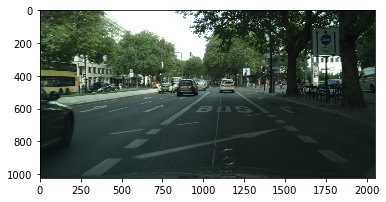

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


time=  2.5784614086151123


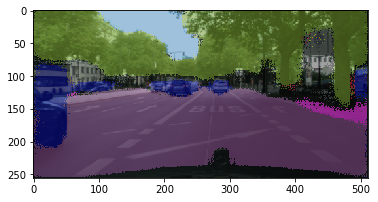

In [27]:
segmen=SSeg()
image_pred = scipy.misc.imread("./data/test.png")
plt.imshow(image_pred)
plt.show()
img_out= segmen.prediction_image(image_pred)
plt.imshow(img_out)
plt.show()